# Hill Climbing

---

In this notebook, we will train hill climbing with adaptive noise scaling with [OpenAI Gym's Cartpole environment](https://gym.openai.com/envs/CartPole-v0/).

### Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Define Policy

In [8]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('Low', env.observation_space.low)
print('High', env.observation_space.high)
print('action space:', env.action_space)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Low [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
action space: Discrete(2)


In [9]:
class Policy():
    
    def __init__(self, s_size=4, a_size=2):
        
        # weights for simple linear policy: state_space x action_space
        self.weights = 1e-4 * np.random.rand(s_size, a_size)
        
    def forward(self, state):
        
        x = np.dot(state, self.weights)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

### Train the Agent with Stochastic Policy Search

In [85]:
env = gym.make('CartPole-v0')
seed = 5
env.seed(seed)
np.random.seed(seed)

In [86]:
policy = Policy()

In [87]:
def hill_climbing(n_episodes=1000, 
                  max_t=1000, 
                  gamma=1.0,
                  print_every=100,
                  noise_scale=1e-2):

    """
    
    Implementation of hill climbing with adaptive noise scaling.
        
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    
    """
    
    scores_deque = deque(maxlen=100)
    scores = []
    best_Reward = -np.Inf
    best_weights = policy.weights
    
    for episodes in range(1, n_episodes + 1):
        
        rewards = []
        state = env.reset()
        
        for t in range(max_t):
            
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            
            if done:
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        Reward = sum([a*b for a,b in zip(discounts, rewards)])
        
        # Found Better Weight
        if Reward >= best_Reward:
            best_Reward = Reward
            best_weights = policy.weights
            
            # This is the noise we are going to add to the weights
            noise_scale = max(1e-3, noise_scale / 2)
            policy.weights += noise_scale * np.random.rand(*policy.weights.shape)
         
        # Did not find better weights
        else:
            
            # Heavier Scaling since we did not find any bigger
            noise_scale = min(2, noise_scale * 2)
            policy.weights = best_weights + (noise_scale * np.random.rand(*policy.weights.shape))
        
            # print('Episode {}\tNoise Scale: {:.2f}'.format(episodes, noise_scale), end='')
            
        if episodes % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(episodes, np.mean(scores_deque)))
            
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episodes, np.mean(scores_deque)))
            policy.weights = best_weights
            break
        
    return scores

### Plot Scores

Episode 100	Average Score: 163.28
Environment solved in 147 episodes!	Average Score: 195.01


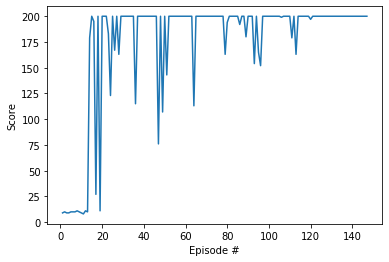

In [88]:
scores = hill_climbing()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent

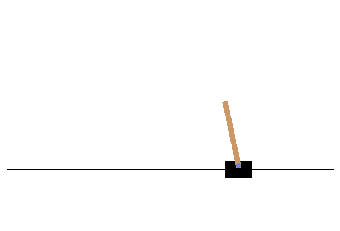

In [89]:
env = gym.make('CartPole-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(200):
    action = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()